# Reading Images and Images Labels

In [11]:
import os
import numpy as np
from PIL import Image
import joblib

def read_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        with Image.open(image_path) as img:
            # Convert image to grayscale and resize if needed
            img = img.convert('L').resize((224, 224))
            # Convert image to NumPy array
            img_array = np.array(img)
            # Normalize pixel values to range [0, 1]
            img_array = img_array / 255.0
            images.append(img_array)
            labels.append(label)
    return images, labels

# Path to the folders containing anomaly and normal images
anomaly_folder = "/content/drive/MyDrive/Group_project/Anomaly"
normal_folder = "/content/drive/MyDrive/Group_project/Normal"

# Read anomaly images
anomaly_images, anomaly_labels = read_images(anomaly_folder, label=1)
print("Anomaly images read successfully.")

# Read normal images
normal_images, normal_labels = read_images(normal_folder, label=0)
print("Normal images read successfully.")

# Concatenate anomaly and normal images and labels
#X = np.concatenate([anomaly_features, normal_features], axis=0)
X = np.concatenate([anomaly_images, normal_images], axis=0)
y = np.concatenate([anomaly_labels, normal_labels])

print("X shape:", X.shape)
print("y shape:", y.shape)


Anomaly images read successfully.
Normal images read successfully.
X shape: (200, 224, 224)
y shape: (200,)


# Applying PCA

In [12]:
import numpy as np
from sklearn.decomposition import PCA

# Assuming 'X' is your preprocessed image data
X = X.reshape(X.shape[0], -1)  # Flatten images into 1D arrays

# Specify the number of principal components you want to retain
n_components = 100  # You can choose the number based on your needs

# Apply PCA
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Applying SVC

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train a Support Vector Machine (SVM) classifier
svm_classifier = SVC(probability=True)
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 82.50%


In [14]:
from sklearn.metrics import roc_curve, auc
y_proba = svm_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr_simple, tpr_simple, _ = roc_curve(y_test, y_proba)
roc_auc_simple = auc(fpr_simple, tpr_simple)

# Evaluating Model Performance

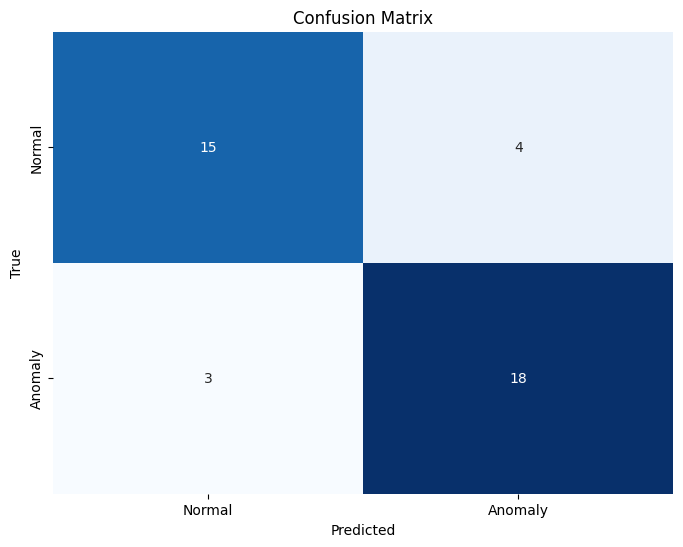

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already trained your classifier and obtained predictions
# Replace y_true with the true labels and y_pred with the predicted labels
# Here is an example:
# y_true = true labels
# y_pred = predicted labels

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

class_labels = ['Normal', 'Anomaly']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

#sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Using Resnet 50(pre_trained) to extract Features

In [16]:
import os
import shutil
import random
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image


# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()

# Preprocess input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to fit ResNet input size
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

# Function to extract features and labels from a folder
def extract_features_and_labels(folder_path, label):
    images = os.listdir(folder_path)
    features = []
    labels = []
    names_ima=[]
    for image_name in images:
        input_image_path = os.path.join(folder_path, image_name)
        names_ima.append(image_name)
        input_image = Image.open(input_image_path)
        input_tensor = transform(input_image)
        input_batch = input_tensor.unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            features_tensor = model(input_batch)
        feature_vector = features_tensor.squeeze().numpy()
        features.append(feature_vector)
        labels.append(label)
    return features, labels,names_ima
dest_anomaly_folder="/content/drive/MyDrive/Group_project/Anomaly"
# Extract features and labels from anomaly images
anomaly_features, anomaly_labels, names_ima = extract_features_and_labels(dest_anomaly_folder, label=1)
print("Anomaly features extracted successfully.")
dest_normal_folder="/content/drive/MyDrive/Group_project/Normal"
# Extract features and labels from normal images
normal_features, normal_labels,names_ima = extract_features_and_labels(dest_normal_folder, label=0)
print("Normal features extracted successfully.")

# Combine anomaly and normal features and labels
X = anomaly_features + normal_features
y = anomaly_labels + normal_labels

print("Total number of samples:", len(X))
print("Total number of anomaly samples:", sum(anomaly_labels))
print("Total number of normal samples:", len(normal_labels))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Anomaly features extracted successfully.
Normal features extracted successfully.
Total number of samples: 200
Total number of anomaly samples: 100
Total number of normal samples: 100





#SVM Classifier

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Support Vector Machine (SVM) classifier
svm_classifier = SVC(probability=True)
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
#joblib.dump(svm_classifier,"/content/drive/MyDrive/Group_project/model.pkl")

Accuracy: 87.50%


In [18]:
from sklearn.metrics import roc_curve, auc
y_proba = svm_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr_resnet50, tpr_resnet50, _ = roc_curve(y_test, y_proba)
roc_auc_resnet50 = auc(fpr_simple, tpr_simple)

#Evaluation

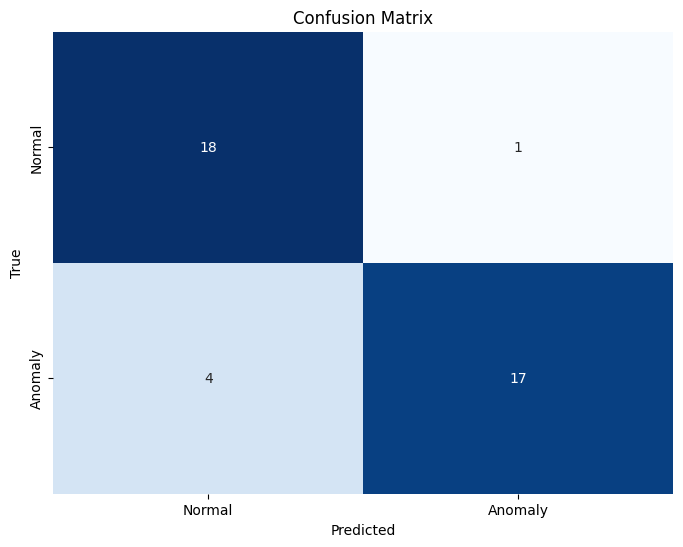

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already trained your classifier and obtained predictions
# Replace y_true with the true labels and y_pred with the predicted labels
# Here is an example:
# y_true = true labels
# y_pred = predicted labels

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

class_labels = ['Normal', 'Anomaly']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

#sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# hyperparameter tuning

In [20]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.01, 0.1, 1, 'scale']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test Score:", test_score)

Best Hyperparameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.90625
Test Score: 0.925


In [21]:
y_pred=best_model.predict(X_test)

In [22]:
from sklearn.metrics import roc_curve, auc
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr_hp, tpr_hp, _ = roc_curve(y_test, y_proba)
roc_auc_hp = auc(fpr_hp, tpr_hp)


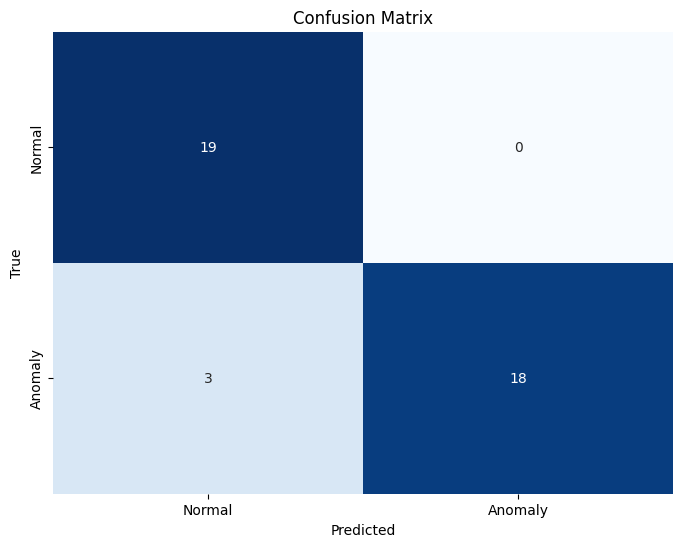

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
class_labels = ['Normal', 'Anomaly']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

#sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# VGG16

In [3]:
import os
import shutil
import random
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image


# Load pre-trained ResNet-50 model
model = models.vgg16(pretrained=True)
model.eval()

# Preprocess input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to fit ResNet input size
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

# Function to extract features and labels from a folder
def extract_features_and_labels(folder_path, label):
    images = os.listdir(folder_path)
    features = []
    labels = []
    names_ima=[]
    for image_name in images:
        input_image_path = os.path.join(folder_path, image_name)
        names_ima.append(image_name)
        input_image = Image.open(input_image_path)
        input_tensor = transform(input_image)
        input_batch = input_tensor.unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            features_tensor = model(input_batch)
        feature_vector = features_tensor.squeeze().numpy()
        features.append(feature_vector)
        labels.append(label)
    return features, labels,names_ima
dest_anomaly_folder="/content/drive/MyDrive/Group_project/Anomaly"
# Extract features and labels from anomaly images
anomaly_features, anomaly_labels, names_ima = extract_features_and_labels(dest_anomaly_folder, label=1)
print("Anomaly features extracted successfully.")
dest_normal_folder="/content/drive/MyDrive/Group_project/Normal"
# Extract features and labels from normal images
normal_features, normal_labels,names_ima = extract_features_and_labels(dest_normal_folder, label=0)
print("Normal features extracted successfully.")

# Combine anomaly and normal features and labels
X = anomaly_features + normal_features
y = anomaly_labels + normal_labels

print("Total number of samples:", len(X))
print("Total number of anomaly samples:", sum(anomaly_labels))
print("Total number of normal samples:", len(normal_labels))


Anomaly features extracted successfully.
Normal features extracted successfully.
Total number of samples: 200
Total number of anomaly samples: 100
Total number of normal samples: 100


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Support Vector Machine (SVM) classifier
svm_classifier = SVC(probability=True)
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
#joblib.dump(svm_classifier,"/content/drive/MyDrive/Group_project/prototype.pkl")

Accuracy: 92.50%


['/content/drive/MyDrive/Group_project/prototype.pkl']

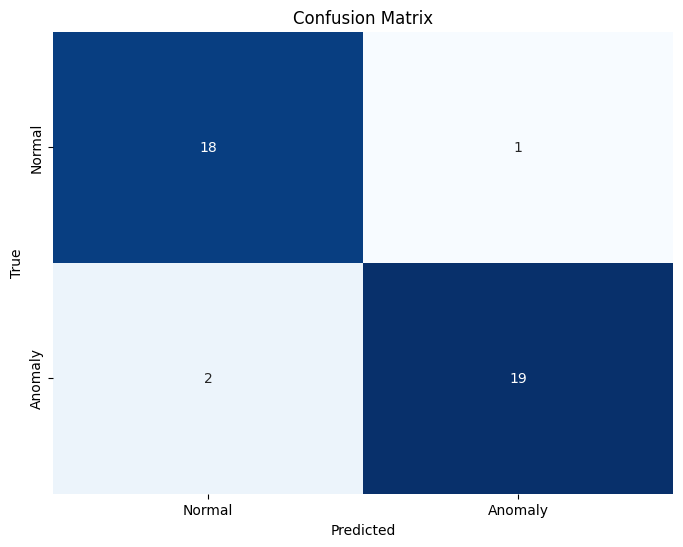

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
class_labels = ['Normal', 'Anomaly']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

#sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


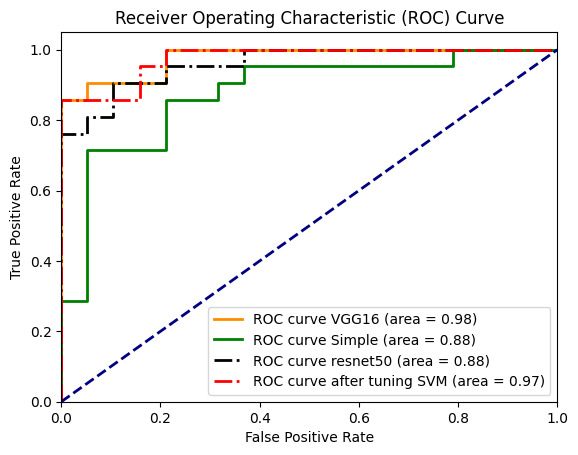

In [28]:
from sklearn.metrics import roc_curve, auc
y_proba = svm_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve VGG16 (area = %0.2f)' % roc_auc)
plt.plot(fpr_simple, tpr_simple, color='green', lw=2, label='ROC curve Simple (area = %0.2f)' % roc_auc_simple)
plt.plot(fpr_resnet50, tpr_resnet50, color='black', lw=2, label='ROC curve resnet50 (area = %0.2f)' % roc_auc_resnet50,linestyle="dashdot")
plt.plot(fpr_hp, tpr_hp, color='red', lw=2, label='ROC curve after tuning SVM (area = %0.2f)' % roc_auc_hp,linestyle="dashdot")


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()